# Week 5: Speech transcription with whisper

This notebook gives an introduction to the [whisper model](https://openai.com/index/whisper/) by OpenAI that can transcribe raw audio and return text. In this notebook you will see a bit about how whisper works and there will be some tasks for to preprocess recorded audio for making it suitable to be processed by whisper.

### Setting up your Python environment

Before you work through this notebook, please follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb)

Once you have done that you will need to make sure that the environment selected to run this notebook and all the other notebooks used in this unit is called `aim`. 

To do this click the **Select kernel** button in the top right corner of this notebook, and then select `aim`.

To make sure that is configured properly, Hit the run cell button (▶) on the cell below:

In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

aim


Does it output the text `aim`?

If it does not output the text `aim`, please revisit and follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb).

If you still cannot get it working, please raise this with the course instructor. 

### Install python packages

Here you now need to install the openai-whisper and pyttsx3 (python speech to text 3) libraries to be used in this and subsequent notebooks:

In [ ]:
!pip install openai-whisper

### Load libraries

Now load the libraries you will need for this notebook:

In [74]:
import torch
import torch.nn.functional as F

import whisper
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import sounddevice as sd
import numpy as np
import librosa

### Load and transcribe audio

Listen to this [reenactment by Thomas Edison](https://publicdomainreview.org/collection/edison-reading-mary-had-a-little-lamb-1927/), which was recorded on the 50th anniversary of [his patent for the 'phonograph'](https://www.wnyc.org/story/86604-today-in-history-thomas-edison/) the first ever device for recording audio. The was a reenactment of the first ever recording of audio, and in it Thomas Edison read out loud the nursery rhyme [Mary had a little lamb](https://en.wikipedia.org/wiki/Mary_Had_a_Little_Lamb).

In [39]:
ipd.Audio("media/audio/thomas-edison-mary-had-a-little-lamb.mp3")

Now you can use whisper to transcribe it into text:

In [40]:
model = whisper.load_model("turbo")
audio = whisper.load_audio("media/audio/thomas-edison-mary-had-a-little-lamb.mp3")
result = model.transcribe(audio)

/Users/tbroad/miniconda3/envs/aim/lib/python3.10/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_locatio

And now you can see the results. How well did it perform?

In [41]:
print(result['text'])

 The first words I spoke in the original phonograph, a little piece of practical poetry. Mary had a little lamb, its streets were quite as slow, and everywhere that Mary went, the lamb was sure to go.


### Whisper transcription step-by-step

The function `model.trascribe()` has hidden a number of things from what is really going on. Now lets take a deeper look to see how it is processsing the data.

First lets take a look at the what is in the variable `audio`:

In [48]:
print(type(audio))
print(audio.shape)
print(audio)

<class 'numpy.ndarray'>
(281287,)
[0. 0. 0. ... 0. 0. 0.]


Run the next cell to visualise the waveform with matplotlib. The x-axis represents the samples and the y-axis represents the amplitude of the audio signal.

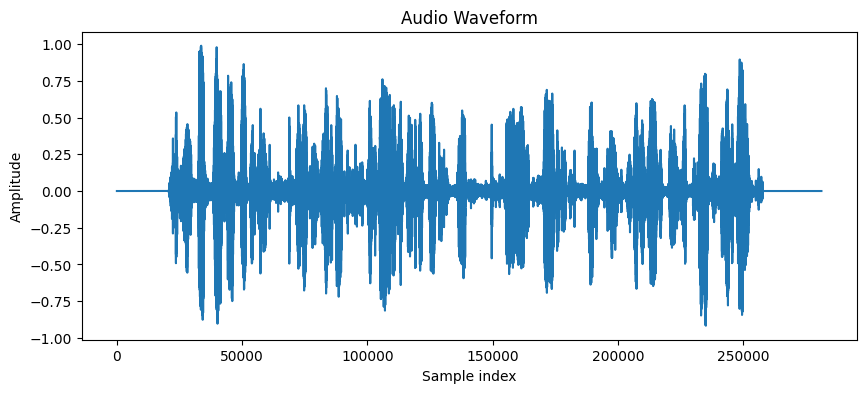

In [49]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

Whisper does not process the waveform directly, occasionally this is done with neural networks, but it can be very inefficient.In machine learning and many other areas of audio signal processing, [spectrograms](https://en.wikipedia.org/wiki/Spectrogram) are an alternative representation of audio (as a collection of frequencies and their relative strength) that is a much more efficient (compressed) representation of an audio signal.

Run the next cell to take a look at the spectrogram of this audio signal:

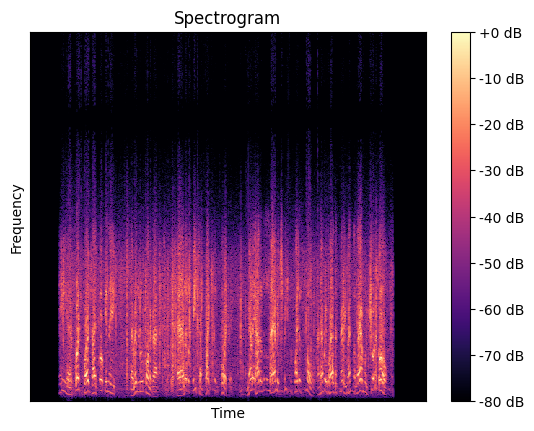

In [51]:
D = librosa.stft(audio)  
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.show()

This however is still the not the most efficient representation available for the task of speech processing. The [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a an alternative scale for representing frequencies that aligns much more closely with the human perception of different pitches. For tasks like speech processing this is particularly useful because speech and (how the interpret it) is very closely tied up with how humans understand and perceive audio signals. 

Run the next cell the convert the audio signal into a mel spectrogram (a frequency spectrogram in the mel scale) to see what it looks like:

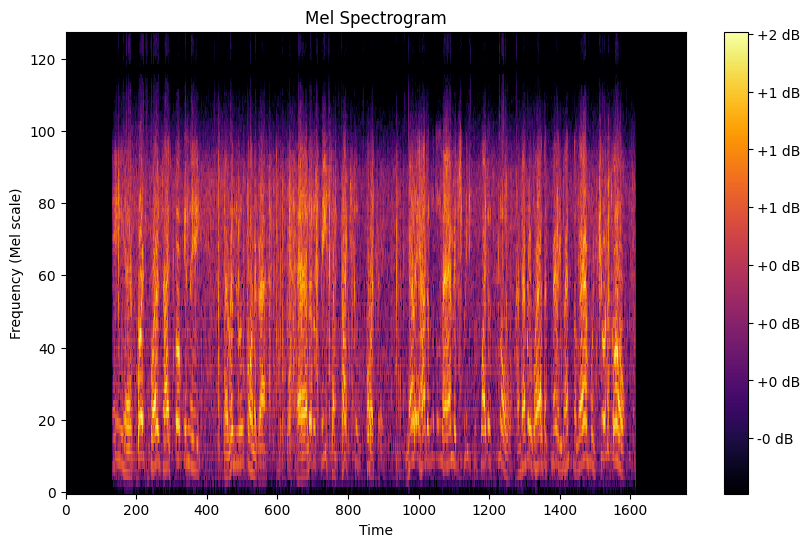

In [53]:
mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel.numpy(), aspect='auto', origin='lower', cmap='inferno', interpolation='none')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Mel scale)")
plt.colorbar(format="%+2.0f dB")
plt.show()

Now run the next cell to try and decode this mel-spectrogram with the whisper network:

In [31]:
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

print(result.language)
print(result.text)

AssertionError: incorrect audio shape

You will have got an error. 

This is because whisper is built to process audio in exactly 30-second blocks. To get decode the mel-spectrogram you first have to the util function in whisper called `pad_or_trim`:

In [62]:
audio = whisper.pad_or_trim(audio, 16000*30)

Now look at what this signal looks like now as a spectrogram:

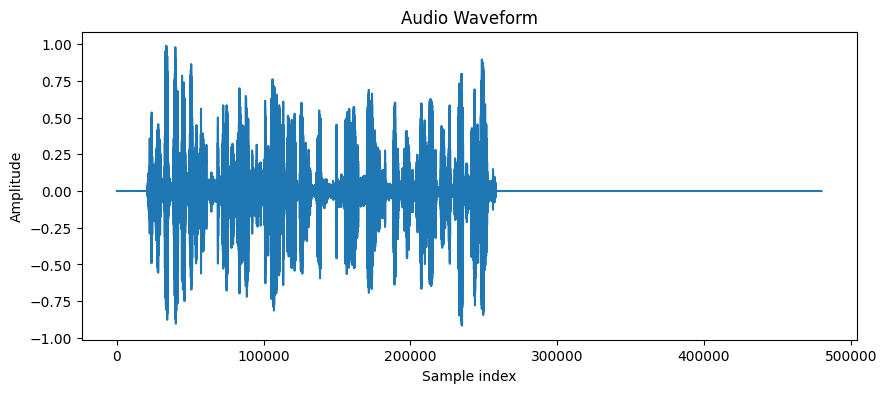

In [63]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

And as a mel-spectrogram:

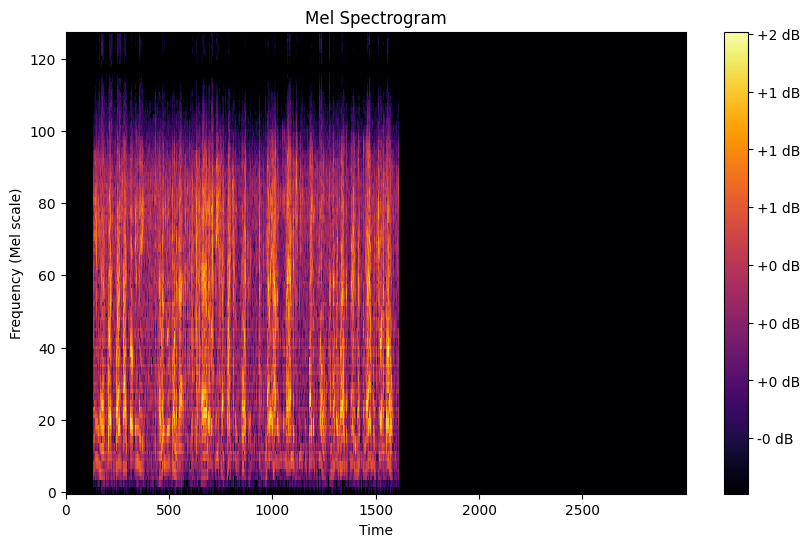

In [64]:
mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels)
mel_np = mel.numpy()

# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel_np, aspect='auto', origin='lower', cmap='inferno', interpolation='none')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Mel scale)")
plt.colorbar(format="%+2.0f dB")
plt.show()

Now you should be able to finally decode this without an error:

In [65]:
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

print(result.text)

The first words I spoke in the original phonograph, a little piece of practical poetry. Mary had a little lamb, its streets were quite as slow, and everywhere that Mary went, the lamb was sure to go.


Whisper can an also make predictions about the language that is being spoken:

In [67]:
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

{'sr': 2.865776423277566e-06, 'be': 5.6918949553619314e-08, 'ms': 4.1230225178878754e-05, 'sn': 2.857861169935916e-10, 'kk': 1.1269968354099547e-06, 'sl': 1.797525692381896e-05, 'yue': 1.8330018058954067e-10, 'uz': 3.728775899158876e-10, 'mg': 2.2500598606534084e-10, 'gu': 2.1977835107378496e-09, 'su': 3.212138055541658e-10, 'da': 4.853277641814202e-05, 'en': 0.989195704460144, 'es': 0.0014183829771354795, 'ps': 7.176239047446131e-10, 'tr': 0.00015726929996162653, 'mk': 9.263158631256374e-07, 'yo': 5.123816371188639e-10, 'pt': 0.0008200880256481469, 'yi': 3.731415176844166e-10, 'ko': 0.0005102496361359954, 'el': 3.735651625902392e-05, 'az': 4.312136297812685e-06, 'hr': 1.0629115422489122e-05, 'si': 4.897547611903974e-08, 'sw': 3.3810213153628865e-06, 'nl': 0.000408115767640993, 'th': 1.2613770195457619e-05, 'br': 7.20363935169388e-10, 'cy': 7.865804946050048e-06, 'haw': 3.384227620362168e-10, 'de': 0.0015652929432690144, 'hy': 1.5520603824370482e-07, 'eu': 1.664810497459257e-06, 'af': 

### Task 1: Transcribing audio recorded from your laptop microphone

Now you are going to use whisper to transcribe audio from your mic.

The following function will record audio from your microphone input on your laptop using the [Python sounddevice](https://python-sounddevice.readthedocs.io/en/0.5.1/) library.

In [71]:
def record_audio(duration=5, samplerate=44100):
    audio = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype=np.int16)
    print('recording')
    sd.wait()
    print('recording complete')
    return audio, samplerate

Run the next cell to record 5 seconds from your microphone. Say something that you want to be transcribed by whisper:

In [115]:
audio_recording, samplerate = record_audio()

recording
recording complete


This should give you a numpy array of shape (220500, 1):

In [116]:
print(type(audio_recording))
print(audio_recording.shape)

<class 'numpy.ndarray'>
(220500, 1)


You can listen to this back, though the `Audio` player expects a vector not a matrix, hence you need to call `.squeeze()` to remove the 'empty' dimensions of the numpy array:

In [117]:
Audio(data=audio_recording.squeeze(), rate=44100)

Now take a look at this spectrogram. What do you notice that is different from the spectrograms from before?

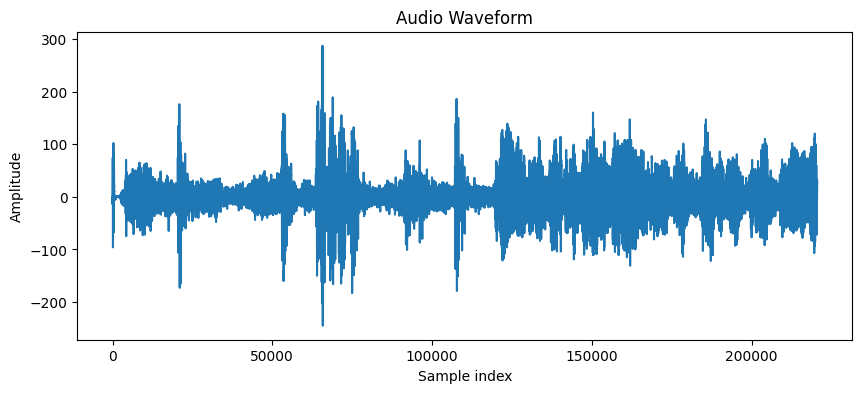

In [118]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_recording.squeeze())
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

There are a few things different about this waveform from the other one. The next steps will walk you through this one by one.

##### Step 1: Convert matrix to vector

Use the either the `.squeeze()` or `.flatten()` function to convert the numpy array `audio_recording` from a matrix to a vector:

In [ ]:
audio_recording =

In [119]:
audio_recording = audio_recording.squeeze()

Now test the code:

In [120]:
assert audio_recording.shape == (220500,)

##### Step 2: Normalise audio

First you will need to normalise the audio to be between -1 & 1. You will need to change the data type of the numpy array from int16 to float32. Use the `np.astype()` function to do this.

After you have done this divide every value in the numpy array by 32768.0 to normalise the amplitudes to be range -1 & 1.

In [ ]:
audio_recording = 

In [121]:
audio_recording = audio_recording.astype(np.float32) / 32768.0

Now test the code:

In [122]:
assert audio_recording.dtype == np.float32
assert audio_recording.max() < 1
assert audio_recording.min() > -1

And see what it looks like:

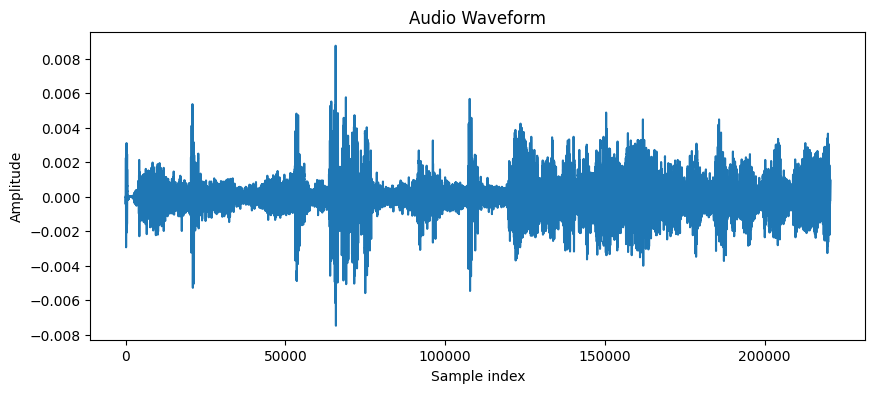

In [123]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_recording)
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

And see what it looks like:

##### Step 3: Resample audio

Whisper has been trained on audio that is at a sample rate of 16000, which is quite a bit lower than the sample rate of 441000 that is used as standard in audio recording and playback. This lower sample rate is used because human speech does mostly happens in a lower frequencies that humans can perceive. 

Use the [resample function from librosa](https://librosa.org/doc/main/generated/librosa.resample.html) to resample the audio from 44100 to 16000:

In [ ]:
audio_recording = 

In [124]:
audio_recording = librosa.resample(audio_recording, orig_sr=44100, target_sr=16000)

In [125]:
print(audio_recording.shape)

(80000,)


Now test your code:

In [126]:
assert audio_recording.shape == (80000,)

And see what it looks like:

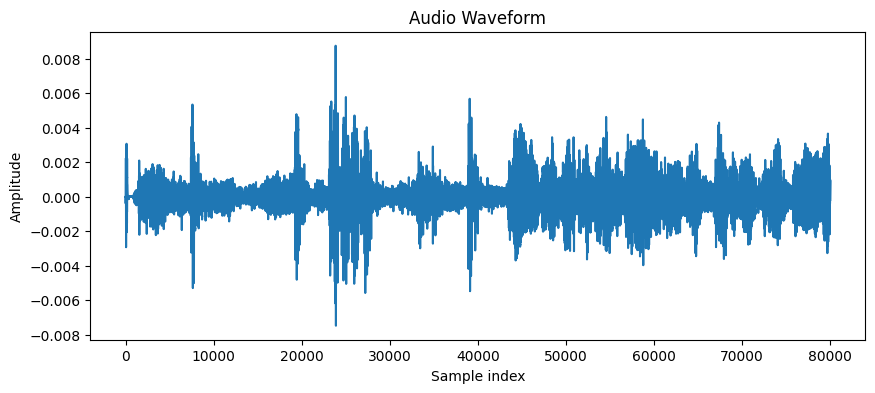

In [127]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_recording)
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

##### Step 4: Zero pad the audio to 30 seconds long

Now you need to take the 5 second long audio section and pad it to be 30 seconds long as that is what whisper has been trained on.

Use the function `pad_or_trim` from whisper to pad the audio:

In [ ]:
audio_recording = 

In [129]:
audio_recording = whisper.pad_or_trim(audio_recording)

(480000,)


now test the code: 

In [130]:
assert audio_recording.shape == (480000,)

Now visualise it: 

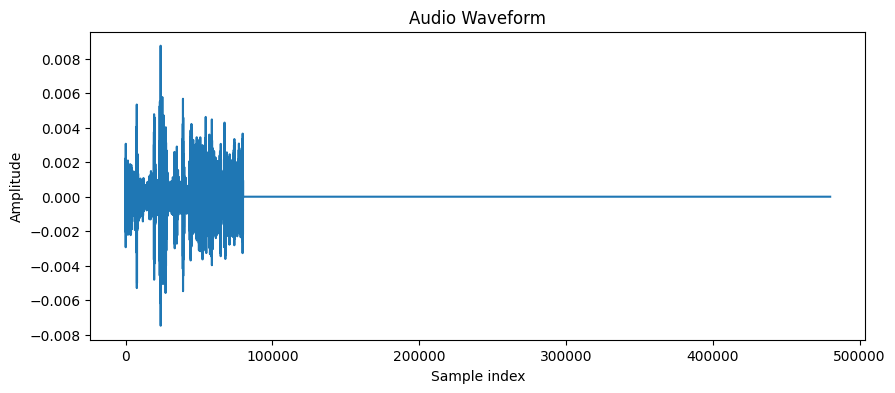

In [131]:
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_recording)
plt.title("Audio Waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

And now test it with whisper:

In [134]:
result = model.transcribe(audio_recording)
print(result['text'])

/Users/tbroad/miniconda3/envs/aim/lib/python3.10/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 I'm also happy to say that I finally can find


##### Step 5: Bring it all together

Take the steps from tasks 1-4 and put them all together into the function, `preprocess_audio`. Make sure you have default values for `original_sr` and `target_sr`:

In [132]:
def preprocess_audio(audio_input, original_sr = , target_sr = ):
    #
    # Your code here
    # 
    return # return processed audio here

SyntaxError: invalid syntax (2565505934.py, line 1)

In [135]:
def preprocess_audio(audio_input, original_sr = 44100, target_sr = 16000):
    audio_input = audio_input.squeeze()
    audio_input = audio_input.astype(np.float32) / 32768.0
    audio_input = librosa.resample(audio_input, orig_sr=original_sr, target_sr=target_sr)
    audio_input = whisper.pad_or_trim(audio_input)
    return audio_input

Now test this code with a new recording. Make sure to say something as the recording is happening:

In [136]:
audio_recording_test, samplerate = record_audio()

recording
recording complete


Now test your function:

In [137]:
processed_audio = preprocess_audio(audio_recording_test)

assert processed_audio.shape == (480000,)
assert processed_audio.dtype == np.float32
assert processed_audio.max() < 1
assert processed_audio.min() > -1

Now see the transcription with whisper:

In [138]:
result = model.transcribe(processed_audio)
print(result['text'])

/Users/tbroad/miniconda3/envs/aim/lib/python3.10/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Hello, hello, hello. Hello, hello, hello.


### Task 2: Building a conversational app 

**Step A:** Now take the functions `record_audio` and `preprocess_audio` and copy and paste them into [week-5b-voice-chatbot-streamlit-app.py](week-5b-voice-chatbot-streamlit-app.py). 

**Step B:** Replace the `print` calls with `st.write` calls to display the information to the user in the app.

**Step C:** In the code block `if st.button("Record and Chat"):` write code that records audio from the microphone, preprocesses it, transcribes it from whisper and puts the resulting text into a variable called `user_text`.

**Step D:** In the code block `if user_text:` Pass the variable user text into the function `get_llm_response` to get a response to the users input from [SmolLM](https://huggingface.co/blog/smollm) (this code is provided for you). After getting the response display it to web interface using `st.write`. 

**Step E:** Run `stream run week-5b-voice-chatbot-streamlit-app.py` to test out your voice activated chatbot.


## Taking it further

To take this further you can try either of the following:

- Use a more advanced instruct-LLM transformer model from the [huggingface transformers library](https://huggingface.co/docs/transformers/en/index) to get better responses. 
- Find and use a text-to-speech model in pytorch to get the code to read back the answers to the user (you may want to create or clone a new conda environment for this).